# 1. Setup

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="whitegrid")

# 2. Data Preprocessing

In [92]:
SEED = 42

train_q = pd.read_excel("data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL_METADATA.xlsx")

train_combined = pd.merge(train_q, train_c, on='participant_id', how='left').set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "Label IDs do not match train IDs"

In [93]:
train_combined

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,13.463381,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zpU7rEseBMH8,100.00,14.0,3.0,11.0,41.0,16.0,23.0,24.0,0.0,8.0,...,12.669860,2017,1,0.0,3.0,2.0,12.0,20.0,21.0,45.0
zpr8w4jCfVPe,100.00,14.0,3.0,9.0,41.0,22.0,10.0,29.0,1.0,15.0,...,NaN,2019,3,1.0,2.0,3.0,12.0,5.0,21.0,35.0
zwBG0rZ05Mcb,46.67,13.0,3.0,12.0,30.0,18.0,14.0,24.0,0.0,10.0,...,8.155258,2016,1,0.0,0.0,2.0,15.0,35.0,18.0,35.0


In [94]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [95]:
label_df = labels.copy()

# Plot: ADHD_Outcome
# plt.figure(figsize=(6, 4))
# sns.countplot(x=label_df["ADHD_Outcome"], palette="Set2")
# plt.title("Distribution of ADHD_Outcome")
# plt.xticks([0, 1], ['No ADHD (0)', 'ADHD (1)'])
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# # Plot: Sex_F
# plt.figure(figsize=(6, 4))
# sns.countplot(x=label_df["Sex_F"], palette="pastel")
# plt.title("Distribution of Sex_F")
# plt.xticks([0, 1], ['Male (0)', 'Female (1)'])
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()


## 2.1 Numerical Features Visualization

In [96]:
numerical_features = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'
]

print(len(numerical_features))

18


In [97]:
numerical_features_df = train_combined[numerical_features]

def nan_summary(df, name):
    print(f"---- {name} NAN SUMMARY ----")
    print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False), '\n')

nan_summary(numerical_features_df, "TRAIN NUMERICAL FEATURES")

---- TRAIN NUMERICAL FEATURES NAN SUMMARY ----
MRI_Track_Age_at_Scan         29.678483
ColorVision_CV_Score           1.896125
EHQ_EHQ_Total                  1.071723
APQ_P_APQ_P_ID                 0.989283
APQ_P_APQ_P_INV                0.989283
APQ_P_APQ_P_OPD                0.989283
APQ_P_APQ_P_PM                 0.989283
APQ_P_APQ_P_PP                 0.989283
APQ_P_APQ_P_CP                 0.989283
SDQ_SDQ_Conduct_Problems       0.741962
SDQ_SDQ_Emotional_Problems     0.741962
SDQ_SDQ_Externalizing          0.741962
SDQ_SDQ_Generating_Impact      0.741962
SDQ_SDQ_Hyperactivity          0.741962
SDQ_SDQ_Internalizing          0.741962
SDQ_SDQ_Peer_Problems          0.741962
SDQ_SDQ_Prosocial              0.741962
SDQ_SDQ_Difficulties_Total     0.741962
dtype: float64 



### 2.1.1 EHQ_EHQ_Total

In [98]:
feature_1 = 'EHQ_EHQ_Total'

median_value = train_combined[feature_1].median()
train_combined[feature_1] = train_combined[feature_1].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature_1].median()
test_combined[feature_1] = test_combined[feature_1].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Filled NaN with median value: 77.8
Filled NaN with median value: 73.37


In [99]:
# plt.figure(figsize=(10, 4))
# sns.boxplot(data=train_combined, x='EHQ_EHQ_Total')
# plt.title("Box Plot of EHQ_|EHQ_Total")
# plt.xlabel("EHQ_EHQ_Total")
# plt.show()

In [100]:
def categorize_laterality(li):
    if -110 <= li <= -28:
        return "Left-Lateralized"
    elif -28 < li <= 47:
        return 'Middle'
    elif 47 < li <= 110:
        return 'Right-Lateralized'

train_combined['Laterality_Category'] = train_combined['EHQ_EHQ_Total'].apply(categorize_laterality)
test_combined['Laterality_Category'] = test_combined['EHQ_EHQ_Total'].apply(categorize_laterality)

In [101]:
# plt.figure(figsize=(8, 4))
# sns.countplot(data=train_combined, x="Laterality_Category", order=["Left-Lateralized", "Middle", "Right-Lateralized"])
# plt.title("Distribution of Laterality Index Categories")
# plt.xlabel("Brain Laterality")
# plt.ylabel("Number of Participants")
# plt.tight_layout()
# plt.show()

### 2.1.2 ColorVision_CV_Score

In [102]:
train_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", train_combined["ColorVision_CV_Score"].isna().sum())

test_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", test_combined["ColorVision_CV_Score"].isna().sum())

Missing values after fill: 0
Missing values after fill: 0


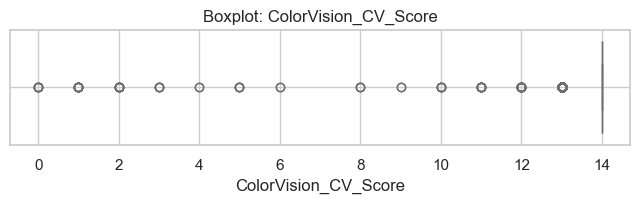

In [103]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined['ColorVision_CV_Score'], color="skyblue")
plt.title('Boxplot: ColorVision_CV_Score')
plt.xlabel('ColorVision_CV_Score')
plt.grid(True)
plt.show()

### 2.1.3 APQ_P_APQ_P_CP

In [104]:
nan_count = train_combined['APQ_P_APQ_P_CP'].isna().sum()
print(f"Number of NaN values in APQ_P_APQ_P_CP: {nan_count}")

median_cp = train_combined['APQ_P_APQ_P_CP'].median()
train_combined['APQ_P_APQ_P_CP'] = train_combined['APQ_P_APQ_P_CP'].fillna(median_cp)
print(f"Filled NaNs with median: {median_cp}")

median_test_cp = test_combined['APQ_P_APQ_P_CP'].median()
test_combined['APQ_P_APQ_P_CP'] = test_combined['APQ_P_APQ_P_CP'].fillna(median_test_cp)
print(f"Filled NaNs with median: {median_test_cp}")

Number of NaN values in APQ_P_APQ_P_CP: 12
Filled NaNs with median: 3.0
Filled NaNs with median: 3.0


In [105]:
# cp_scores = train_combined['APQ_P_APQ_P_CP']
# Q1 = cp_scores.quantile(0.25)
# Q3 = cp_scores.quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = cp_scores[(cp_scores < lower_bound) | (cp_scores > upper_bound)]
# print(f"Number of outliers in APQ_P_APQ_P_CP: {len(outliers)}")
# print("Outlier values:")
# print(outliers.values)

# plt.figure(figsize=(8, 4))
# sns.boxplot(x=train_combined['APQ_P_APQ_P_CP'], orient='h', color='lightgreen')
# plt.title('Boxplot of APQ_P_APQ_P_CP (After NaN Imputation)')
# plt.xlabel('Corporal Punishment Score')
# plt.tight_layout()
# plt.show()

In [106]:
# train_combined['APQ_CP_is_high'] = (train_combined['APQ_P_APQ_P_CP'] > 5).astype(int)
# test_combined['APQ_CP_is_high'] = (test_combined['APQ_P_APQ_P_CP'] > 5).astype(int)

In [107]:
# plt.figure(figsize=(6, 4))
# sns.countplot(x=train_combined['APQ_CP_is_high'], palette="Set2")
# plt.title('Distribution of High Corporal Punishment Flag (APQ_CP_is_high)')
# plt.xlabel('Is High Corporal Punishment? (0 = No, 1 = Yes)')
# plt.ylabel('Count')
# plt.xticks([0, 1], ['0 = No', '1 = Yes'])
# plt.tight_layout()
# plt.show()

### 2.1.4: APQ_P_APQ_P_ID

In [108]:
feature = 'APQ_P_APQ_P_ID'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in {feature}: {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature].fillna(median_value, inplace=True)
print(f"Filled NaNs in {feature} with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature].fillna(median_test_value, inplace=True)
print(f"Filled NaNs in {feature} with median value: {median_test_value}")

Number of NaN rows in APQ_P_APQ_P_ID: 12
Filled NaNs in APQ_P_APQ_P_ID with median value: 13.0
Filled NaNs in APQ_P_APQ_P_ID with median value: 13.0


In [109]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in {feature}: {len(outliers)}")

# plt.figure(figsize=(8, 2))
# sns.boxplot(x=train_combined[feature], orient='h')
# plt.title(f'Boxplot of {feature}')
# plt.show()

### 2.1.5: APQ_P_APQ_P_INV

In [110]:
feature = 'APQ_P_APQ_P_INV'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_INV': 12
Filled NaNs in 'APQ_P_APQ_P_INV' with median: 40.0
Filled NaNs in 'APQ_P_APQ_P_INV' with median: 40.0


In [111]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")
# print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="skyblue")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.6: APQ_P_APQ_P_OPD

In [112]:
feature = 'APQ_P_APQ_P_OPD'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_OPD': 12
Filled NaNs in 'APQ_P_APQ_P_OPD' with median: 18.0
Filled NaNs in 'APQ_P_APQ_P_OPD' with median: 17.0


In [113]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")
# print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightgreen")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.7: APQ_P_APQ_P_PM

In [114]:
feature = 'APQ_P_APQ_P_PM'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_PM': 12
Filled NaNs in 'APQ_P_APQ_P_PM' with median: 16.0
Filled NaNs in 'APQ_P_APQ_P_PM' with median: 15.0


In [115]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")
# print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="salmon")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.8 APQ_P_APQ_P_PP

In [116]:
feature = 'APQ_P_APQ_P_PP'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'APQ_P_APQ_P_PP': 12
Filled NaNs in 'APQ_P_APQ_P_PP' with median: 26.0
Filled NaNs in 'APQ_P_APQ_P_PP' with median: 25.0


In [117]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")
# print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="plum")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.9 SDQ_SDQ_Conduct_Problems

In [118]:
feature = 'SDQ_SDQ_Conduct_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaNs in '{feature}' with median: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaNs in '{feature}' with median: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Conduct_Problems': 9
Filled NaNs in 'SDQ_SDQ_Conduct_Problems' with median: 2.0
Filled NaNs in 'SDQ_SDQ_Conduct_Problems' with median: 1.0


In [119]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")
# print(f"Outlier threshold: lower < {lower_bound:.2f}, upper > {upper_bound:.2f}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.10 SDQ_SDQ_Difficulties_Total

In [120]:
feature = 'SDQ_SDQ_Difficulties_Total'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Difficulties_Total': 9
Filled NaN with median value: 12.0
Filled NaN with median value: 11.0


In [121]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.11: SDQ_SDQ_Emotional_Problems

In [122]:
feature = 'SDQ_SDQ_Emotional_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Emotional_Problems': 9
Filled NaN with median value: 2.0
Filled NaN with median value: 2.0


In [123]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.12: SDQ_SDQ_Externalizing

In [124]:
feature = 'SDQ_SDQ_Externalizing'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Externalizing': 9
Filled NaN with median value: 8.0
Filled NaN with median value: 7.0


In [125]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.13: SDQ_SDQ_Generating_Impact

In [126]:
feature = 'SDQ_SDQ_Generating_Impact'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Generating_Impact': 9
Filled NaN with median value: 4.0
Filled NaN with median value: 4.0


In [127]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.14: SDQ_SDQ_Hyperactivity

In [128]:
feature = 'SDQ_SDQ_Hyperactivity'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Hyperactivity': 9
Filled NaN with median value: 6.0
Filled NaN with median value: 6.0


In [129]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.15: SDQ_SDQ_Internalizing

In [130]:
feature = 'SDQ_SDQ_Internalizing'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Internalizing': 9
Filled NaN with median value: 4.0
Filled NaN with median value: 4.0


In [131]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.16: SDQ_SDQ_Peer_Problems

In [132]:
feature = 'SDQ_SDQ_Peer_Problems'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Peer_Problems': 9
Filled NaN with median value: 2.0
Filled NaN with median value: 1.0


In [133]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.17: SDQ_SDQ_Prosocial

In [134]:
feature = 'SDQ_SDQ_Prosocial'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

Number of NaN rows in feature 'SDQ_SDQ_Prosocial': 9
Filled NaN with median value: 8.0
Filled NaN with median value: 8.0


In [135]:
# Q1 = train_combined[feature].quantile(0.25)
# Q3 = train_combined[feature].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
# print(f"Number of outliers in '{feature}': {len(outliers)}")

# plt.figure(figsize=(8, 1.5))
# sns.boxplot(x=train_combined[feature], color="lightcoral")
# plt.title(f'Boxplot of {feature}')
# plt.xlabel(feature)
# plt.tight_layout()
# plt.show()

### 2.1.18: MRI_Track_Age_at_Scan

In [136]:
feature = 'MRI_Track_Age_at_Scan'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

Number of NaN rows in feature 'MRI_Track_Age_at_Scan': 360


In [137]:
numeric_data = train_combined[numerical_features].copy()
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=100, random_state=SEED)

numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data), 
    columns=numerical_features, 
    index=numeric_data.index
)
train_combined['MRI_Track_Age_at_Scan'] = numeric_data_imputed['MRI_Track_Age_at_Scan']


test_numeric_data = test_combined[numerical_features].copy()
test_numeric_data_imputed = pd.DataFrame(
    imputer.transform(test_numeric_data),
    columns=numerical_features,
    index=test_numeric_data.index
)
test_combined['MRI_Track_Age_at_Scan'] = test_numeric_data_imputed['MRI_Track_Age_at_Scan']

Number of outliers in 'MRI_Track_Age_at_Scan': 16


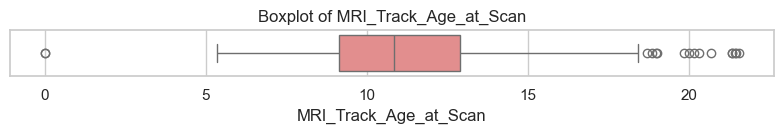

In [138]:
Q1 = train_combined[feature].quantile(0.25)
Q3 = train_combined[feature].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_combined[(train_combined[feature] < lower_bound) | (train_combined[feature] > upper_bound)]
print(f"Number of outliers in '{feature}': {len(outliers)}")

plt.figure(figsize=(8, 1.5))
sns.boxplot(x=train_combined[feature], color="lightcoral")
plt.title(f'Boxplot of {feature}')
plt.xlabel(feature)
plt.tight_layout()
plt.show()

In [139]:
# train_combined.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score'], inplace=True)
# test_combined.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score'], inplace=True)

## 2.2 Categorical Features Visualization

In [140]:
categorical_features = [
    'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ', 'Laterality_Category', 'ColorVision_Level',
    'APQ_CP_is_high'
]

print(len(categorical_features))   

12


### 2.2.1 Basic_Demos_Enroll_Year

In [141]:
feature = 'Basic_Demos_Enroll_Year'
nan_count_train = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count_train}")
nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'Basic_Demos_Enroll_Year': 0
Number of NaN rows in test feature 'Basic_Demos_Enroll_Year': 0


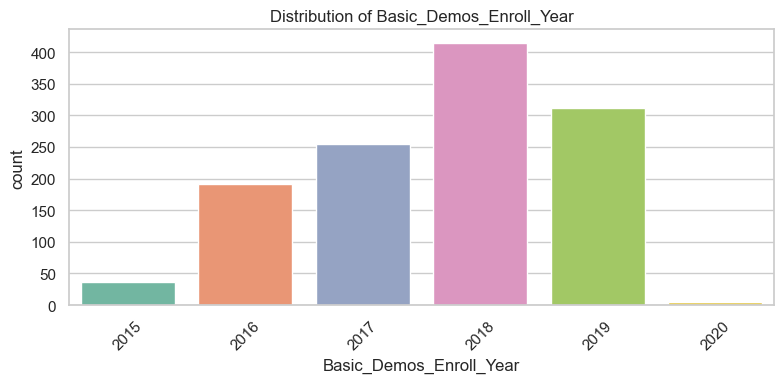

In [142]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette="Set2")
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

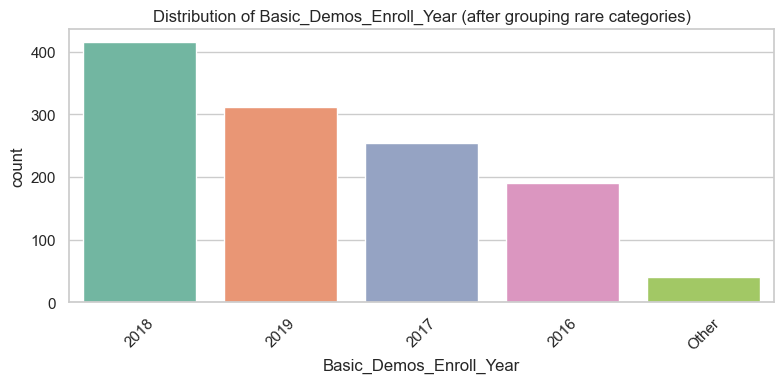

In [143]:
# Step 1: Compute rare categories from TRAIN only
threshold = 50

# Step 1: Handle rare categories in TRAIN
category_counts = train_combined[feature].value_counts()
rare_categories = category_counts[category_counts < threshold].index
train_combined[feature] = train_combined[feature].apply(
    lambda x: 'Other' if x in rare_categories else str(x)
)

# Step 2: Handle rare + unseen categories in TEST
# Convert to str first so categories match
test_combined[feature] = test_combined[feature].astype(str)

# Map test values to 'Other' if not in train (incl. unseen or rare ones)
allowed_categories = set(train_combined[feature].unique())

test_combined[feature] = test_combined[feature].apply(
    lambda x: x if x in allowed_categories else 'Other'
)

plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette="Set2", order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature} (after grouping rare categories)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [144]:
train_combined[feature] = train_combined[feature].replace({4: 0})
test_combined[feature] = test_combined[feature].replace({4: 0})

### 2.2.2: Basic_Demos_Study_Site

In [145]:
feature = 'Basic_Demos_Study_Site'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'Basic_Demos_Study_Site': 0
Number of NaN rows in test feature 'Basic_Demos_Study_Site': 0


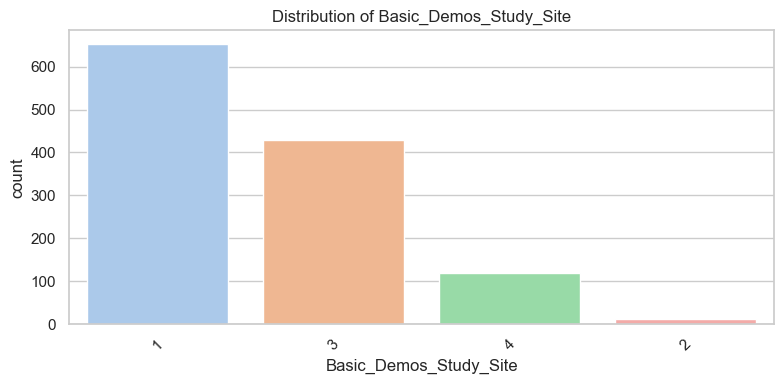

In [146]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rare categories in 'Basic_Demos_Study_Site' (fewer than 25 instances):
Index([], dtype='int64', name='Basic_Demos_Study_Site')


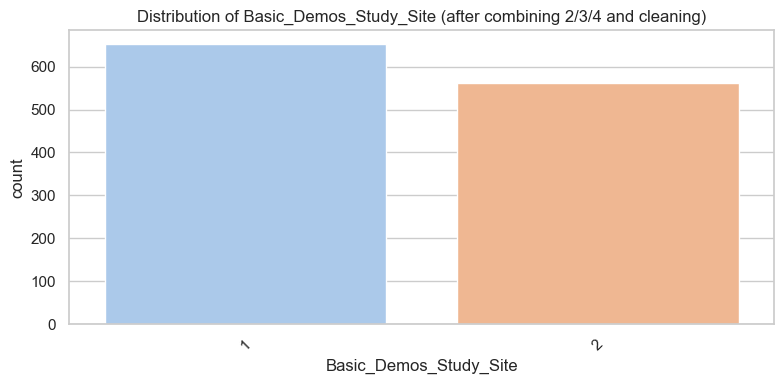

In [147]:
# Step 1: Combine 2, 3, and 4 into 2
train_combined[feature] = train_combined[feature].replace({3: 2, 4: 2})
test_combined[feature] = test_combined[feature].replace({3: 2, 4: 2})

# Step 2: Handle rare categories
threshold = 25
category_counts = train_combined[feature].value_counts()
rare_categories = category_counts[category_counts < threshold].index

print(f"Rare categories in '{feature}' (fewer than {threshold} instances):")
print(rare_categories)

# Step 3: Replace rare categories with 'Other'
train_combined[feature] = train_combined[feature].apply(
    lambda x: 'Other' if x in rare_categories else str(x)
)
test_combined[feature] = test_combined[feature].apply(
    lambda x: 'Other' if x in rare_categories else str(x)
)

# Step 4: Plot updated TRAIN distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature} (after combining 2/3/4 and cleaning)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.3: PreInt_Demos_Fam_Child_Ethnicity

In [148]:
feature = 'PreInt_Demos_Fam_Child_Ethnicity'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_count_test = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_count_test}")

Number of NaN rows in feature 'PreInt_Demos_Fam_Child_Ethnicity': 43
Number of NaN rows in test feature 'PreInt_Demos_Fam_Child_Ethnicity': 3


In [149]:
train_combined[feature] = train_combined[feature].fillna(3.0)
test_combined[feature] = test_combined[feature].fillna(3.0)

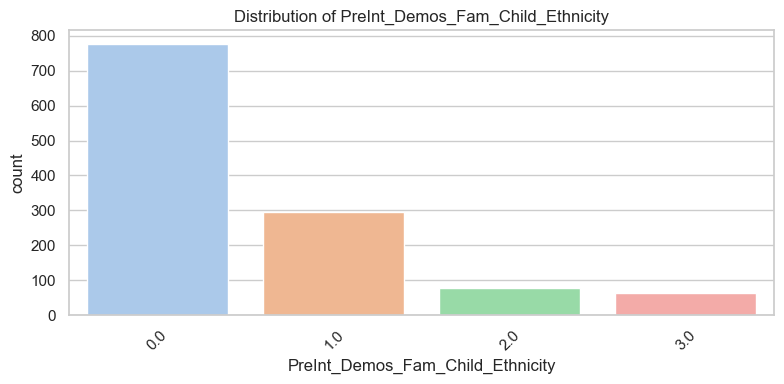

In [150]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

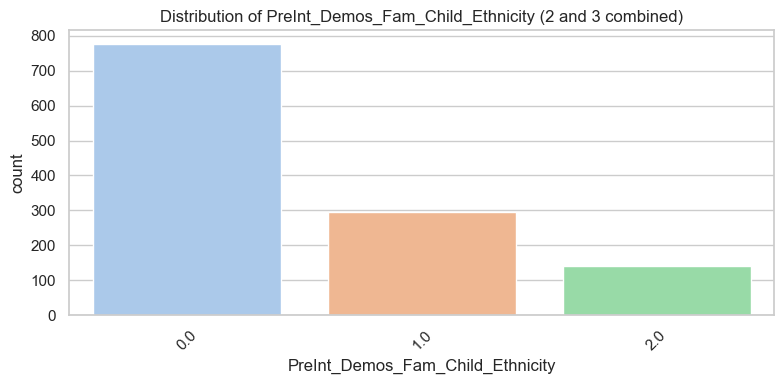

In [151]:
# combine values 2 and 3
train_combined[feature] = train_combined[feature].replace({3: 2})
test_combined[feature] = test_combined[feature].replace({3: 2})

plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature} (2 and 3 combined)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.4: PreInt_Demos_Fam_Child_Race

In [152]:
feature = 'PreInt_Demos_Fam_Child_Race'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'PreInt_Demos_Fam_Child_Race': 54
Number of NaN rows in test feature 'PreInt_Demos_Fam_Child_Race': 6


In [153]:
train_combined[feature] = train_combined[feature].fillna(10.0)
test_combined[feature] = test_combined[feature].fillna(10.0)

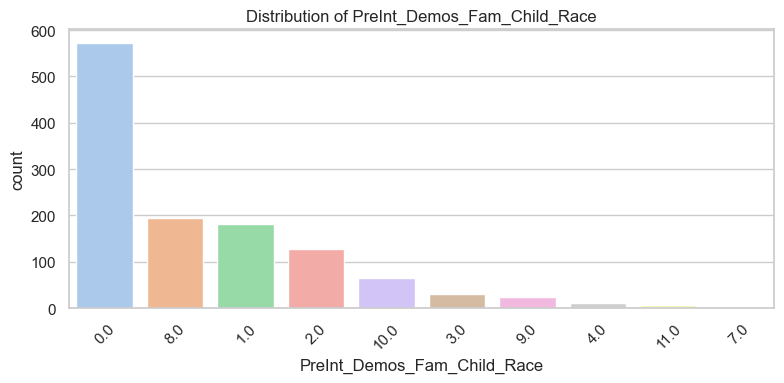

In [154]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

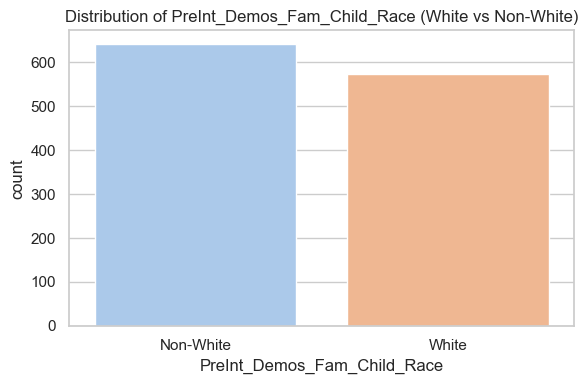

In [155]:
# Step 1: Map values
train_combined[feature] = train_combined[feature].apply(lambda x: "White" if x == 0.0 else "Non-White")
test_combined[feature] = test_combined[feature].apply(lambda x: "White" if x == 0.0 else "Non-White")

# Step 2: Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=train_combined[feature], palette='pastel', 
              order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature} (White vs Non-White)")
plt.tight_layout()
plt.show()

### 2.2.5: MRI_Track_Scan_Location

In [156]:
feature = 'MRI_Track_Scan_Location'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'MRI_Track_Scan_Location': 3
Number of NaN rows in test feature 'MRI_Track_Scan_Location': 0


In [157]:
train_combined[feature] = train_combined[feature].fillna(4.0)
test_combined[feature] = test_combined[feature].fillna(4.0)

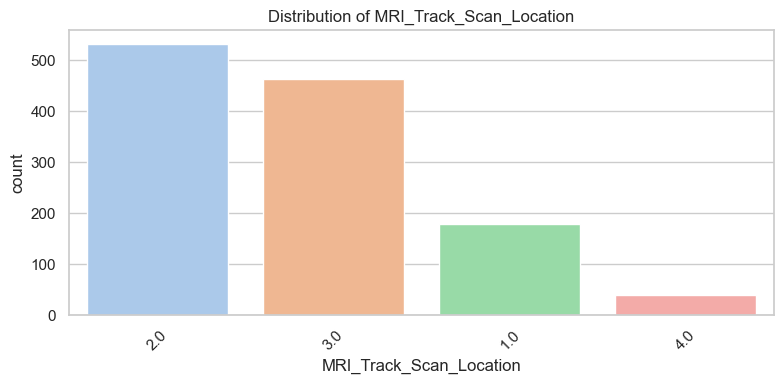

In [158]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

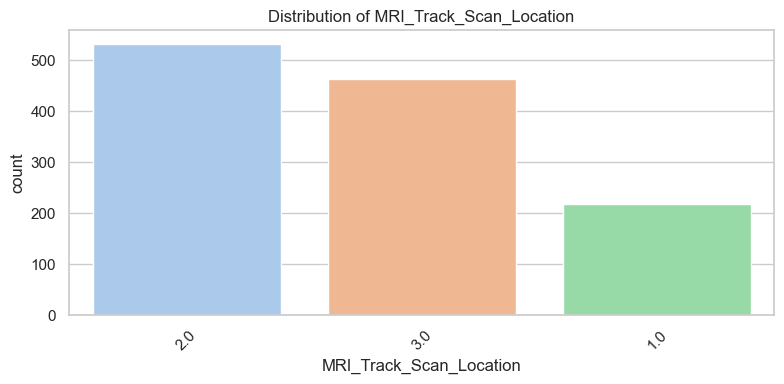

In [159]:
# combine values 1 and 4
train_combined[feature] = train_combined[feature].replace({4: 1})
test_combined[feature] = test_combined[feature].replace({4: 1})

plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.6: Barratt_Barratt_P1_Edu

In [160]:
feature = 'Barratt_Barratt_P1_Edu'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P1_Edu': 15
Number of NaN rows in test feature 'Barratt_Barratt_P1_Edu': 1


In [161]:
train_combined[feature] = train_combined[feature].fillna(18.0)
test_combined[feature] = test_combined[feature].fillna(18.0)

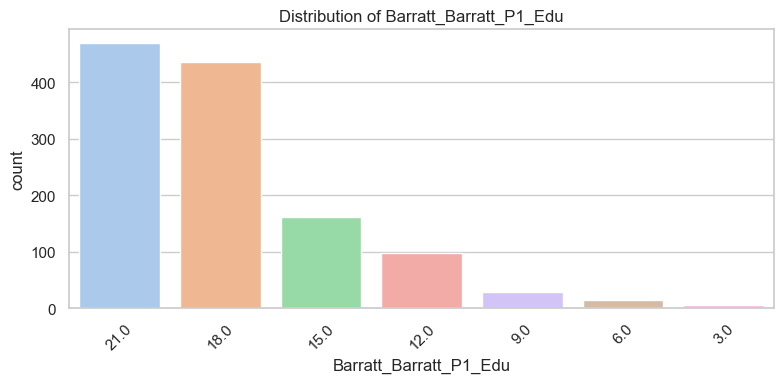

In [162]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [163]:
def collapse_edu(value):
    if value == 21.0:
        return "Upper_College"
    elif value == 18.0:
        return "College"
    else:
        return "Under_College"
    
train_combined[feature] = train_combined[feature].apply(collapse_edu)
test_combined[feature] = test_combined[feature].apply(collapse_edu)

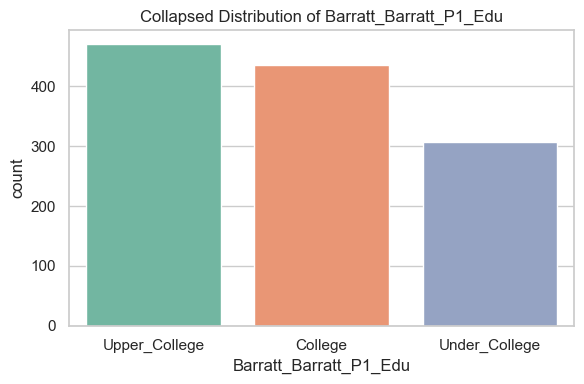

In [164]:
# Plot updated distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=train_combined[feature], palette='Set2', order=train_combined[feature].value_counts().index)
plt.title(f"Collapsed Distribution of {feature}")
plt.tight_layout()
plt.show()

### 2.2.7: Barratt_Barratt_P1_Occ

In [165]:
feature = 'Barratt_Barratt_P1_Occ'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P1_Occ': 31
Number of NaN rows in test feature 'Barratt_Barratt_P1_Occ': 1


In [166]:
median_value = train_combined[feature].median()
train_combined[feature] = train_combined[feature].fillna(median_value)
print(f"Filled NaN in '{feature}' with median value: {median_value}")

median_test_value = test_combined[feature].median()
test_combined[feature] = test_combined[feature].fillna(median_test_value)
print(f"Filled NaN in '{feature}' with median value: {median_test_value}")

Filled NaN in 'Barratt_Barratt_P1_Occ' with median value: 30.0
Filled NaN in 'Barratt_Barratt_P1_Occ' with median value: 35.0


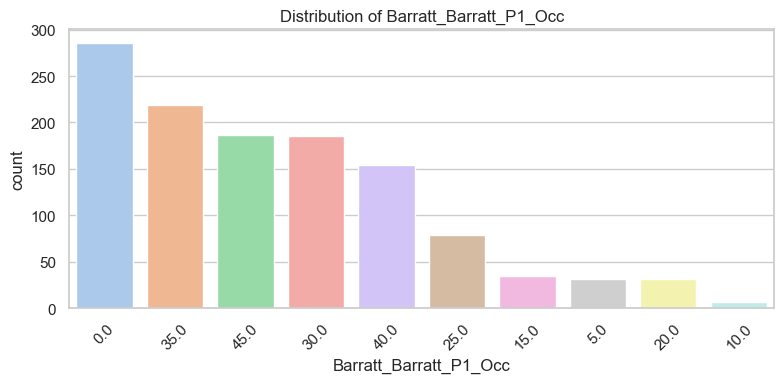

In [167]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [168]:
def collapse_occupation(val):
    if val in [0.0, 5.0, 10.0, 15.0]:
        return "Low"
    elif val in [20.0, 25.0]:
        return "LowerMid"
    elif val in [30.0, 35.0, 40.0]:
        return "UpperMid"
    elif val == 45.0:
        return "High"
    else:
        return "Other"  # Safety fallback

feature = "Barratt_Barratt_P1_Occ"

train_combined[feature] = train_combined[feature].apply(collapse_occupation)
test_combined[feature] = test_combined[feature].apply(collapse_occupation)

### 2.2.8: Barratt_Barratt_P2_Edu

In [169]:
feature = 'Barratt_Barratt_P2_Edu'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P2_Edu': 198
Number of NaN rows in test feature 'Barratt_Barratt_P2_Edu': 36


In [170]:
def collapse_edu(value):
    if value == 21.0:
        return "Upper_College"
    elif value == 18.0:
        return "College"
    else:
        return "Under_College"
    
train_combined[feature] = train_combined[feature].apply(collapse_edu)
test_combined[feature] = test_combined[feature].apply(collapse_edu)

In [171]:
def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Edu']):
        return row['Barratt_Barratt_P1_Edu']
    return row['Barratt_Barratt_P2_Edu']

train_combined['Barratt_Barratt_P2_Edu'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Edu'] = test_combined.apply(impute_p2_edu, axis=1)

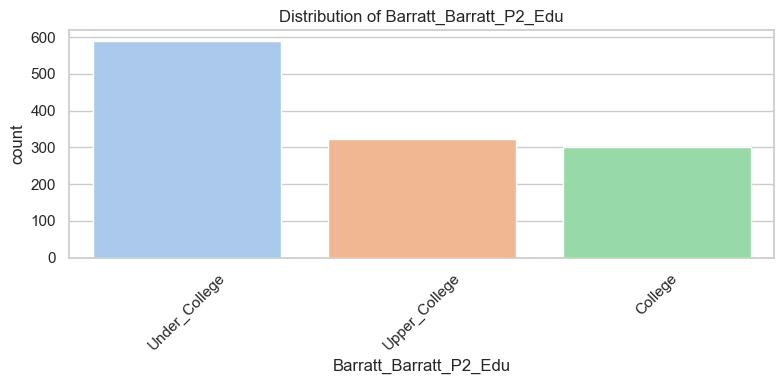

In [172]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.9: Barratt_Barratt_P2_Occ

In [173]:
feature = 'Barratt_Barratt_P2_Occ'
nan_count = train_combined[feature].isna().sum()
print(f"Number of NaN rows in feature '{feature}': {nan_count}")

nan_test_count = test_combined[feature].isna().sum()
print(f"Number of NaN rows in test feature '{feature}': {nan_test_count}")

Number of NaN rows in feature 'Barratt_Barratt_P2_Occ': 222
Number of NaN rows in test feature 'Barratt_Barratt_P2_Occ': 42


In [174]:
def collapse_occupation(val):
    if val in [0.0, 5.0, 10.0, 15.0]:
        return "Low"
    elif val in [20.0, 25.0]:
        return "LowerMid"
    elif val in [30.0, 35.0, 40.0]:
        return "UpperMid"
    elif val == 45.0:
        return "High"
    else:
        return "Other"  # Safety fallback

feature = "Barratt_Barratt_P2_Occ"

train_combined[feature] = train_combined[feature].apply(collapse_occupation)
test_combined[feature] = test_combined[feature].apply(collapse_occupation)

In [175]:
def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Occ']):
        return row['Barratt_Barratt_P1_Occ']
    return row['Barratt_Barratt_P2_Occ']

train_combined['Barratt_Barratt_P2_Occ'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Occ'] = test_combined.apply(impute_p2_edu, axis=1)

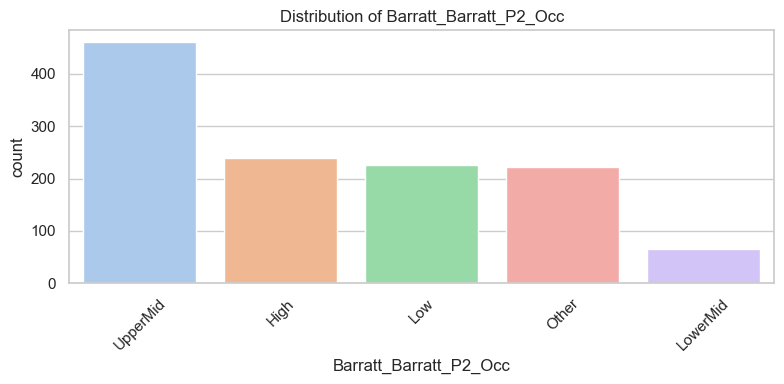

In [176]:
plt.figure(figsize=(8, 4))
sns.countplot(x=train_combined[feature], palette='pastel', order=train_combined[feature].value_counts().index)
plt.title(f"Distribution of {feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [177]:
# train_combined.drop(columns=['MRI_Track_Scan_Location', 'Basic_Demos_Study_Site'], inplace=True)
# test_combined.drop(columns=['MRI_Track_Scan_Location', 'Basic_Demos_Study_Site'], inplace=True)

### 2.2.10 LABEL ENCODING

In [178]:
label_encode_features = [
    'Basic_Demos_Enroll_Year',
    'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ',
    'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ',
    'Laterality_Category'
]

from sklearn.preprocessing import LabelEncoder

encoders = {}  # Store encoders if needed for inverse_transform later

for feature in label_encode_features:
    le = LabelEncoder()
    train_combined[feature] = le.fit_transform(train_combined[feature])
    test_combined[feature] = le.transform(test_combined[feature])
    encoders[feature] = le  # Save encoder

In [179]:
# Updated binary map: White = 1, Non-White = 0
binary_map = {
    'White': 1,
    'Non-White': 0,
}

# Apply to 'PreInt_Demos_Fam_Child_Race'
train_combined['PreInt_Demos_Fam_Child_Race'] = train_combined['PreInt_Demos_Fam_Child_Race'].map(binary_map)
test_combined['PreInt_Demos_Fam_Child_Race'] = test_combined['PreInt_Demos_Fam_Child_Race'].map(binary_map)

# 3. Final

In [180]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'Laterality_Category'],
      dtype='object')

In [181]:
test_combined

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Laterality_Category
participant_id,,,,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,...,4,2,0.0,1,1,2,3,0,4,2
vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,...,4,2,0.0,1,1,2,0,1,4,2
ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,...,4,2,0.0,1,1,2,3,0,4,1
LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,...,4,2,0.0,1,3,2,0,2,0,2
EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,...,4,2,2.0,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UadZfjdEg7eG,86.71,14.0,3.0,17.0,41.0,17.0,11.0,25.0,1.0,18.0,...,4,2,0.0,1,1,0,1,0,4,2
IUEHiLmQAqCi,73.37,14.0,5.0,12.0,38.0,22.0,9.0,29.0,2.0,16.0,...,4,2,0.0,0,3,0,3,2,4,2
cRySmCadYFRO,87.84,13.0,3.0,14.0,42.0,15.0,10.0,28.0,1.0,11.0,...,4,2,0.0,0,1,2,2,1,3,2


In [182]:
for feature in train_combined.columns:
    num_missing = train_combined[feature].isna().sum()
    print(f"{feature}: {num_missing} missing values")

EHQ_EHQ_Total: 0 missing values
ColorVision_CV_Score: 0 missing values
APQ_P_APQ_P_CP: 0 missing values
APQ_P_APQ_P_ID: 0 missing values
APQ_P_APQ_P_INV: 0 missing values
APQ_P_APQ_P_OPD: 0 missing values
APQ_P_APQ_P_PM: 0 missing values
APQ_P_APQ_P_PP: 0 missing values
SDQ_SDQ_Conduct_Problems: 0 missing values
SDQ_SDQ_Difficulties_Total: 0 missing values
SDQ_SDQ_Emotional_Problems: 0 missing values
SDQ_SDQ_Externalizing: 0 missing values
SDQ_SDQ_Generating_Impact: 0 missing values
SDQ_SDQ_Hyperactivity: 0 missing values
SDQ_SDQ_Internalizing: 0 missing values
SDQ_SDQ_Peer_Problems: 0 missing values
SDQ_SDQ_Prosocial: 0 missing values
MRI_Track_Age_at_Scan: 0 missing values
Basic_Demos_Enroll_Year: 0 missing values
Basic_Demos_Study_Site: 0 missing values
PreInt_Demos_Fam_Child_Ethnicity: 0 missing values
PreInt_Demos_Fam_Child_Race: 0 missing values
MRI_Track_Scan_Location: 0 missing values
Barratt_Barratt_P1_Edu: 0 missing values
Barratt_Barratt_P1_Occ: 0 missing values
Barratt_Barr

In [183]:
for feature in test_combined.columns:
    num_missing = test_combined[feature].isna().sum()
    print(f"{feature}: {num_missing} missing values")

EHQ_EHQ_Total: 0 missing values
ColorVision_CV_Score: 0 missing values
APQ_P_APQ_P_CP: 0 missing values
APQ_P_APQ_P_ID: 0 missing values
APQ_P_APQ_P_INV: 0 missing values
APQ_P_APQ_P_OPD: 0 missing values
APQ_P_APQ_P_PM: 0 missing values
APQ_P_APQ_P_PP: 0 missing values
SDQ_SDQ_Conduct_Problems: 0 missing values
SDQ_SDQ_Difficulties_Total: 0 missing values
SDQ_SDQ_Emotional_Problems: 0 missing values
SDQ_SDQ_Externalizing: 0 missing values
SDQ_SDQ_Generating_Impact: 0 missing values
SDQ_SDQ_Hyperactivity: 0 missing values
SDQ_SDQ_Internalizing: 0 missing values
SDQ_SDQ_Peer_Problems: 0 missing values
SDQ_SDQ_Prosocial: 0 missing values
MRI_Track_Age_at_Scan: 0 missing values
Basic_Demos_Enroll_Year: 0 missing values
Basic_Demos_Study_Site: 0 missing values
PreInt_Demos_Fam_Child_Ethnicity: 0 missing values
PreInt_Demos_Fam_Child_Race: 0 missing values
MRI_Track_Scan_Location: 0 missing values
Barratt_Barratt_P1_Edu: 0 missing values
Barratt_Barratt_P1_Occ: 0 missing values
Barratt_Barr

In [184]:
# Reset index to include participant_id as a column
train_combined.reset_index(inplace=True)
test_combined.reset_index(inplace=True)

In [185]:
train_combined.to_csv('train_processed_ver1.csv', index=False)
test_combined.to_csv('test_processed_ver1.csv', index=False)

print("Complete!")

Complete!


In [186]:
# train_combined.to_csv('train_processed.csv', index=False)
# test_combined.to_csv('test_processed.csv', index=False)

# print("Complete!")